# Malaria Detection using Machine Learning with Dimension Reduction

## Project Overview
This notebook implements a comprehensive approach to malaria detection from blood cell images using various machine learning techniques with a focus on dimension reduction methods.

### Dataset Challenges and Preprocessing Strategy

**Mixed Image Formats Issue:**
- The dataset contains images in different formats (.tiff and .png)
- For consistent processing, we will standardize all images to PNG format
- This ensures uniform handling across the entire pipeline

**Class Imbalance Problem:**
- Training set: 4,000 negative vs 800 positive samples (~5:1 ratio)
- Validation set: 1,531 negative vs 1,035 positive samples (~1.5:1 ratio)
- This significant imbalance requires special handling techniques

### Techniques to Handle Class Imbalance:

1. **Data-Level Approaches:**
   - **Data Augmentation:** Apply transformations specifically to minority class

2. **Algorithm-Level Approaches:**
   - **Class Weights:** Assign higher weights to minority class during training

3. **Evaluation Strategies:**
   - **Stratified Cross-Validation:** Maintain class distribution in folds
   - **Balanced Metrics:** Use F1-score, precision, recall, and AUC-ROC instead of just accuracy
   - **Confusion Matrix Analysis:** Detailed analysis of true/false positives and negatives

4. **Ensemble Methods:**
   - **Balanced Random Forest:** Built-in handling of class imbalance
   - **EasyEnsemble:** Combine multiple balanced classifiers
   - **BalanceCascade:** Sequential ensemble with balanced sampling

### Implementation Plan:
We will implement and compare multiple approaches to find the most effective combination for this specific dataset and problem.


## Data Exploration and Preprocessing

In this section, we will:
1. Load and examine the dataset structure
2. Analyze image properties and distributions
3. Visualize sample images from both classes
4. Implement preprocessing pipeline for format standardization
5. Apply class imbalance handling techniques
6. Prepare data for dimension reduction experiments


In [14]:
import os
from pathlib import Path
import matplotlib.pyplot as plt

# Set up plotting parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [15]:
BASE_PATH = Path('malaria_dataset')
TRAIN_PATH = BASE_PATH / 'train'
VAL_PATH = BASE_PATH / 'val'

TRAIN_NEGATIVE = TRAIN_PATH / 'negative'
TRAIN_POSITIVE = TRAIN_PATH / 'positive'
VAL_NEGATIVE = VAL_PATH / 'negative'
VAL_POSITIVE = VAL_PATH / 'positive'

print("Dataset Structure:")
print(f"Base path: {BASE_PATH}")
print(f"Training path: {TRAIN_PATH}")
print(f"Validation path: {VAL_PATH}")


Dataset Structure:
Base path: malaria_dataset
Training path: malaria_dataset/train
Validation path: malaria_dataset/val


When examining the malaria dataset, we noticed that the images come in two different formats: TIFF and PNG. If we train a model directly on this mixed-format dataset, the model may unintentionally learn to distinguish file format artifacts instead of actual malaria parasites. To prevent this and ensure the model learns meaningful medical features, we need to convert all images into a consistent format.

To understand how many images exist in each format, we can run the following cell to count them:

In [19]:
# Function to count files by extension in each directory
def count_files_by_extension(directory):
    """Count files by their extensions in a directory"""
    extensions = {}
    if directory.exists():
        for file_path in directory.iterdir():
            if file_path.is_file():
                ext = file_path.suffix.lower()
                extensions[ext] = extensions.get(ext, 0) + 1
    return extensions

directories = [
    ("Training Negative", TRAIN_NEGATIVE),
    ("Training Positive", TRAIN_POSITIVE), 
    ("Validation Negative", VAL_NEGATIVE),
    ("Validation Positive", VAL_POSITIVE)
]

total_tiff = 0
total_png = 0
total_other = 0

for dir_name, dir_path in directories:
    file_counts = count_files_by_extension(dir_path)
    print(f"\n{dir_name}: {file_counts}")
    
    # Count specific formats
    tiff_count = file_counts.get('.tiff', 0) + file_counts.get('.tif', 0)
    png_count = file_counts.get('.png', 0)
    other_count = sum(count for ext, count in file_counts.items() 
                     if ext not in ['.tiff', '.tif', '.png'])
    
    total_tiff += tiff_count
    total_png += png_count
    total_other += other_count
    
    print(f"  - TIFF files: {tiff_count}")
    print(f"  - PNG files: {png_count}")
    print(f"  - Other files: {other_count}")

print()
print(f"Total TIFF files: {total_tiff}")
print(f"Total PNG files: {total_png}")
print(f"Total other files: {total_other}")
print(f"Total image files: {total_tiff + total_png}")



Training Negative: {'.tiff': 4000}
  - TIFF files: 4000
  - PNG files: 0
  - Other files: 0

Training Positive: {'.png': 800}
  - TIFF files: 0
  - PNG files: 800
  - Other files: 0

Validation Negative: {'.png': 1531}
  - TIFF files: 0
  - PNG files: 1531
  - Other files: 0

Validation Positive: {'.png': 1034, '.db': 1}
  - TIFF files: 0
  - PNG files: 1034
  - Other files: 1

Total TIFF files: 4000
Total PNG files: 3365
Total other files: 1
Total image files: 7365


Based on the above analysis, we see that the dataset contains a mix of TIFF and PNG images, with all Negative training samples in TIFF format (4000 images) and most Positive samples in PNG format (800 training + all validation). Because of this imbalance, the model would learn to distinguish file formats instead of learning malaria-specific visual features. To avoid this issue and ensure consistent preprocessing, we will convert the entire dataset into PNG format.

We choose PNG because more than 45% of the dataset is already in PNG, and PNG is a widely used, lossless image format commonly used in biomedical imaging. In fact, standard malaria image benchmarks; such as the NIH Malaria Dataset (27,558 cell images) also distribute images in PNG/JPEG format, not TIFF. This means PNG is already accepted as a standard for malaria cell classification, and converting everything to PNG ensures compatibility with commonly used deep learning pipelines and pretrained models (e.g., ResNet, VGG), which expect standard RGB inputs rather than high–bit depth TIFF files.

One other files called Thumbs.db, which is a thumbnail cache file for Windows was found in the validation positive directory. We should remove it.

In [24]:
# Image Format Standardization - Convert all images to PNG
from PIL import Image

def convert_images_to_png(source_dir):
    """
    Convert all TIFF images to PNG format in place
    
    Args:
        source_dir: Directory containing images to convert
    """
    if not source_dir.exists():
        print(f"Directory {source_dir} does not exist")
        return
    
    # Get all TIFF files
    tiff_files = list(source_dir.glob('*.tiff')) + list(source_dir.glob('*.tif'))
    
    if not tiff_files:
        print(f"No TIFF files found in {source_dir}")
        return
    
    print(f"Converting {len(tiff_files)} TIFF files to PNG in {source_dir}...")
    
    converted_count = 0
    for tiff_file in tiff_files:
        try:
            # Create PNG filename
            png_file = tiff_file.with_suffix('.png')
            
            # Convert TIFF to PNG
            with Image.open(tiff_file) as img:
                # Convert to RGB if necessary (TIFF might have different modes)
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                
                # Save as PNG
                img.save(png_file, 'PNG', optimize=True)
            
            # Remove original TIFF file
            tiff_file.unlink()
            converted_count += 1
            
            print(f"  ✓ Converted: {tiff_file.name} → {png_file.name}")
            
        except Exception as e:
            print(f"  ✗ Error converting {tiff_file.name}: {e}")
    
    print(f"Successfully converted {converted_count} files to PNG format")

directories_to_convert = [
    ("Training Negative", TRAIN_NEGATIVE),
    ("Training Positive", TRAIN_POSITIVE),
    ("Validation Negative", VAL_NEGATIVE),
    ("Validation Positive", VAL_POSITIVE)
]

for dir_name, dir_path in directories_to_convert:
    print(f"\nProcessing {dir_name}:")
    convert_images_to_png(dir_path)



Processing Training Negative:
No TIFF files found in malaria_dataset/train/negative

Processing Training Positive:
No TIFF files found in malaria_dataset/train/positive

Processing Validation Negative:
No TIFF files found in malaria_dataset/val/negative

Processing Validation Positive:
No TIFF files found in malaria_dataset/val/positive


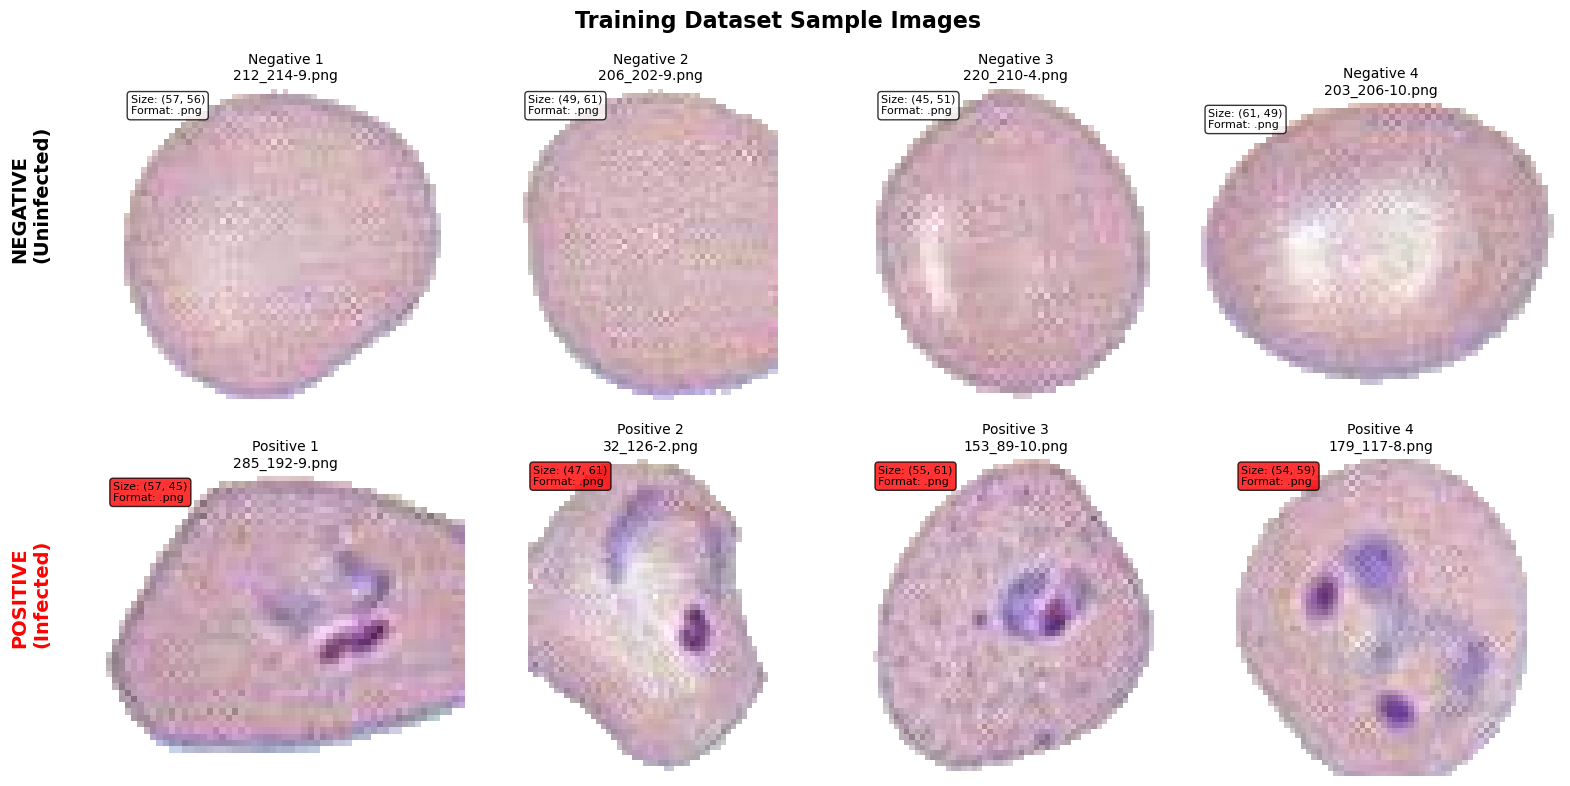

In [31]:
import random

def get_random_image_files(directory, num_samples=4):
    """Get random PNG image files from a directory"""
    image_extension = '.png'
    
    # Get all PNG image files
    image_files = []
    if directory.exists():
        for file_path in directory.iterdir():
            if file_path.is_file() and file_path.suffix.lower() == image_extension:
                image_files.append(file_path)
    
    # Return random sample
    if len(image_files) >= num_samples:
        return random.sample(image_files, num_samples)
    else:
        return image_files

# Function to visualize sample images
def visualize_training_samples():
    """Visualize sample images from training dataset"""
    
    # Get random samples
    negative_samples = get_random_image_files(TRAIN_NEGATIVE, 4)
    positive_samples = get_random_image_files(TRAIN_POSITIVE, 4)
    
    # Create figure with 2 rows and 4 columns
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Training Dataset Sample Images', fontsize=16, fontweight='bold')
    
    # Plot negative samples (top row)
    for i, img_path in enumerate(negative_samples):
        try:
            img = Image.open(img_path)
            axes[0, i].imshow(img)
            axes[0, i].set_title(f'Negative {i+1}\n{img_path.name}', fontsize=10)
            axes[0, i].axis('off')
            
            # Add image info
            axes[0, i].text(0.02, 0.98, f'Size: {img.size}\nFormat: {img_path.suffix}', 
                           transform=axes[0, i].transAxes, fontsize=8, 
                           verticalalignment='top', bbox=dict(boxstyle='round', 
                           facecolor='white', alpha=0.8))
        except Exception as e:
            axes[0, i].text(0.5, 0.5, f'Error loading\n{img_path.name}', 
                           ha='center', va='center', transform=axes[0, i].transAxes)
            axes[0, i].axis('off')
    
    # Plot positive samples (bottom row)
    for i, img_path in enumerate(positive_samples):
        try:
            img = Image.open(img_path)
            axes[1, i].imshow(img)
            axes[1, i].set_title(f'Positive {i+1}\n{img_path.name}', fontsize=10)
            axes[1, i].axis('off')
            
            # Add image info
            axes[1, i].text(0.02, 0.98, f'Size: {img.size}\nFormat: {img_path.suffix}', 
                           transform=axes[1, i].transAxes, fontsize=8, 
                           verticalalignment='top', bbox=dict(boxstyle='round', 
                           facecolor='red', alpha=0.8))
        except Exception as e:
            axes[1, i].text(0.5, 0.5, f'Error loading\n{img_path.name}', 
                           ha='center', va='center', transform=axes[1, i].transAxes)
            axes[1, i].axis('off')
    
    # Add row labels
    fig.text(0.02, 0.75, 'NEGATIVE\n(Uninfected)', fontsize=14, fontweight='bold', 
             rotation=90, verticalalignment='center')
    fig.text(0.02, 0.25, 'POSITIVE\n(Infected)', fontsize=14, fontweight='bold', 
             rotation=90, verticalalignment='center', color='red')
    
    plt.tight_layout()
    plt.subplots_adjust(left=0.08)  # Make room for labels
    plt.show()

# Set random seed for reproducible results
random.seed(42)

# Visualize the samples
visualize_training_samples()
